In [16]:
import pickle

import pandas as pd
from tqdm import tqdm 
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from erc.constants import idx2emotion

In [2]:
from glob import glob 

# load pickle --> RAM 
SAVE_PATH = "./RobertaL_valid_results"

total_emotion = pd.DataFrame()
total_wav_pooled = pd.DataFrame()
total_txt_pooled = pd.DataFrame()

pbar = tqdm(
    total=int(len(glob(SAVE_PATH+'/*.pickle'))), 
    iterable = glob(SAVE_PATH+'/*.pickle'))

for pickle_name in pbar:
    # load
    with open(pickle_name, 'rb') as f:
        data = pickle.load(f)
    # print(data)
    tmp_emotion = pd.DataFrame(data['emotion'].detach().numpy())
    tmp_wav_pooled = pd.DataFrame(data["wav_pooled"])
    tmp_txt_pooled = pd.DataFrame(data["txt_pooled"])
    
    total_emotion = pd.concat([total_emotion,tmp_emotion ], axis=0)
    total_wav_pooled = pd.concat([total_wav_pooled,tmp_wav_pooled ], axis=0)
    total_txt_pooled = pd.concat([total_txt_pooled,tmp_txt_pooled ], axis=0)

del tmp_emotion
del tmp_wav_pooled
del tmp_txt_pooled

total_emotion.columns = ['emotion']

100%|██████████| 585/585 [00:01<00:00, 480.52it/s] 


In [3]:
matmul_output = torch.bmm(torch.from_numpy(total_wav_pooled.values).unsqueeze(2),
                          torch.from_numpy(total_txt_pooled.values).unsqueeze(1))

matmul_output.shape, matmul_output.mean().shape, total_wav_pooled.shape, total_txt_pooled.shape

(torch.Size([4678, 256, 256]), torch.Size([]), (4678, 256), (4678, 256))

In [10]:
def plot_rd(data: np.ndarray,
            dim_reduction: str = "pca",
            n_components: int = 2,
            title: str = "",
            **kwargs):
    
    if dim_reduction is not None:
        tool = {
            "pca": PCA,
            "tsne": TSNE,
        }[dim_reduction](n_components=n_components, **kwargs)
        reduced_data = tool.fit_transform(data)
    else:
        # Pre-transformed data
        reduced_data = data
    
    x, y = np.split(reduced_data.T, indices_or_sections=2)
    x, y = x.squeeze(), y.squeeze()
    for idx, emotion in idx2emotion.items():
        if emotion == "neutral":
            continue
        mask = (total_emotion.emotion == idx).values
        plt.scatter(x=x[mask], y=y[mask], label=emotion, marker='.', alpha=0.7)
        
    if title == "":
        title = f"{dim_reduction.upper()}"
    plt.title(label=title, size="x-large")
    plt.legend();

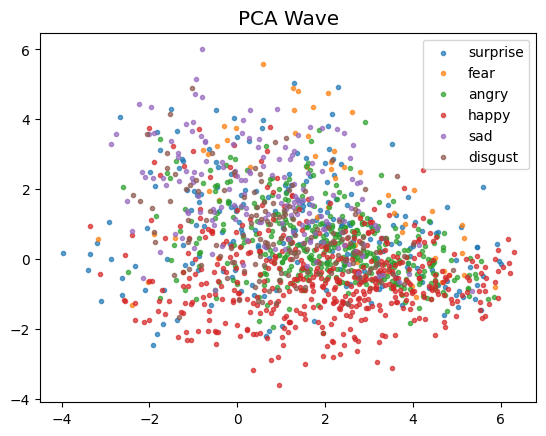

In [13]:
plot_rd(data=total_wav_pooled.values,
        dim_reduction="pca",
        title="PCA Wave",
        random_state=42)

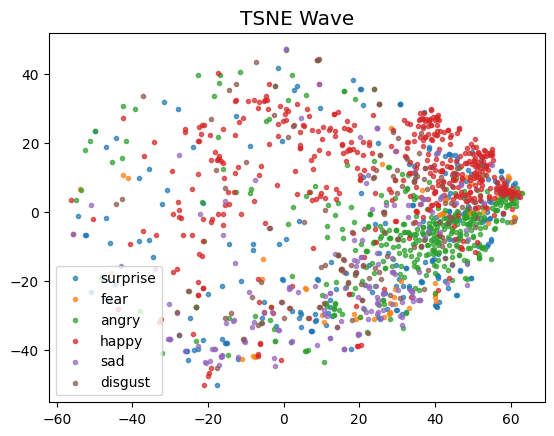

In [14]:
plot_rd(data=total_wav_pooled.values,
        dim_reduction="tsne",
        title="TSNE Wave",
        random_state=42)

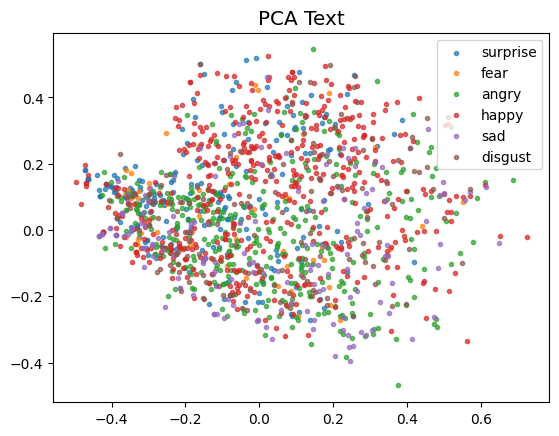

In [12]:
plot_rd(data=total_txt_pooled.values,
        dim_reduction="pca",
        title="PCA Text",
        random_state=42)

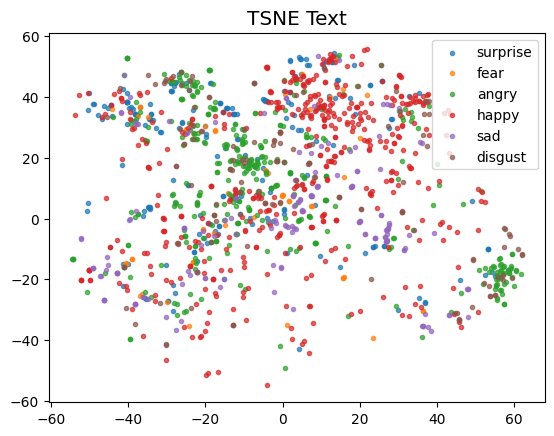

In [15]:
plot_rd(data=total_txt_pooled.values,
        dim_reduction="tsne",
        title="TSNE Text",
        random_state=42)

In [41]:
def plot_sns(data: np.ndarray,
            dim_reduction: str = "pca",
            n_components: int = 2,
            **kwargs):
    
    if dim_reduction is not None:
        tool = {
            "pca": PCA,
            "tsne": TSNE,
        }[dim_reduction](n_components=n_components, **kwargs)
        reduced_data = tool.fit_transform(data)
    else:
        # Pre-transformed data
        reduced_data = data
    
    total_df = pd.DataFrame(reduced_data)
    total_df.columns = ["dim1", "dim2"]
    total_df["emotion"] = total_emotion.emotion.apply(idx2emotion.get).values
    
    sub_df = total_df[total_df["emotion"] != "neutral"]
    sns.jointplot(data=sub_df, x="dim1", y="dim2", hue="emotion",
                  kind="kde", palette="pastel", fill=True, alpha=0.6);

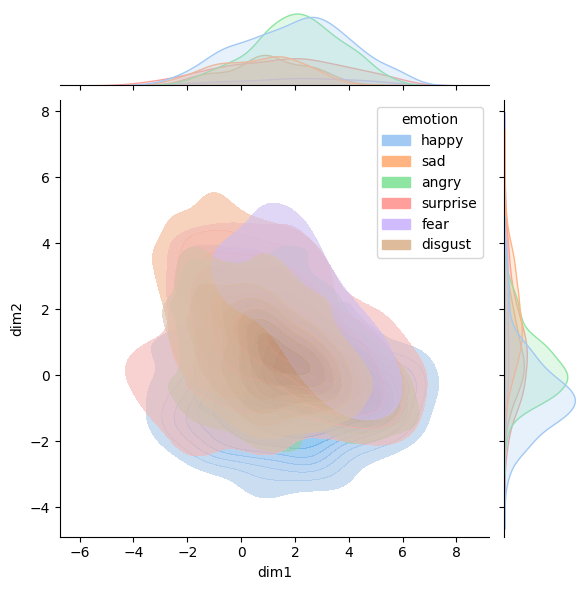

In [42]:
plot_sns(data=total_wav_pooled.values,
         dim_reduction="pca",
         random_state=42)

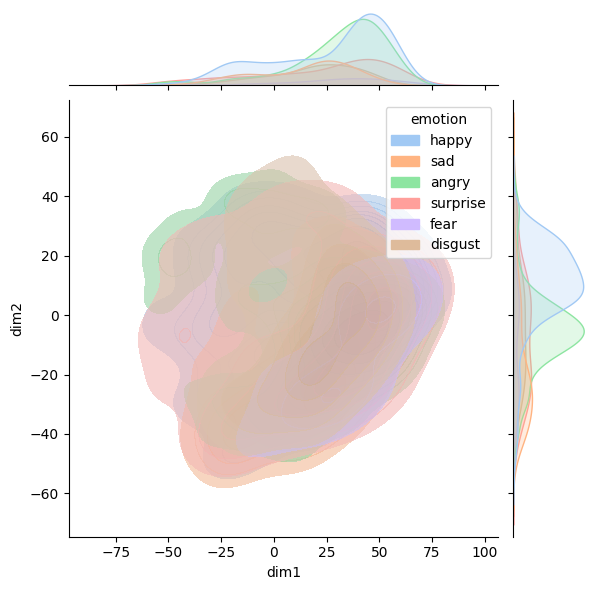

In [43]:
plot_sns(data=total_wav_pooled.values,
         dim_reduction="tsne",
         random_state=42)

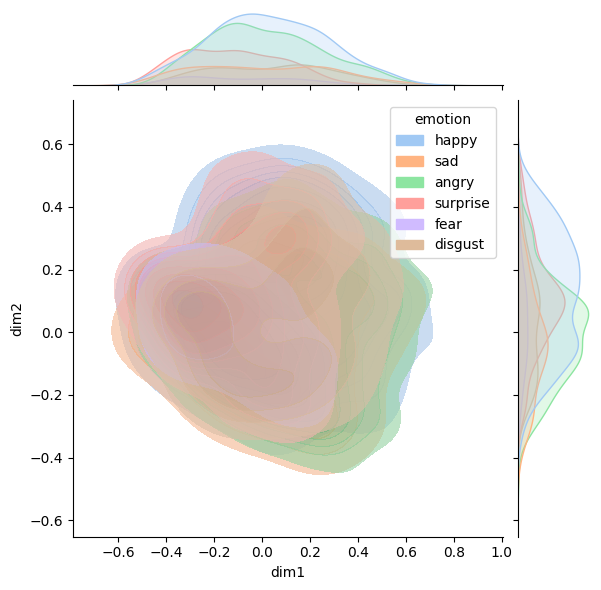

In [44]:
plot_sns(data=total_txt_pooled.values,
         dim_reduction="pca",
         random_state=42)

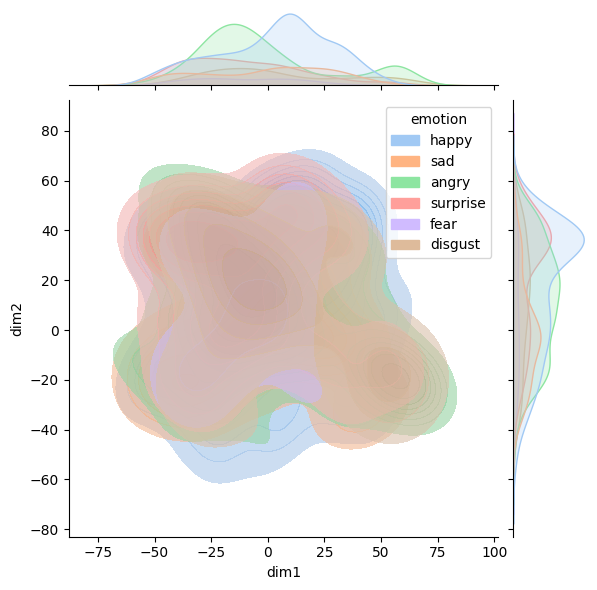

In [45]:
plot_sns(data=total_txt_pooled.values,
         dim_reduction="tsne",
         random_state=42)